In [29]:
import sys, os, glob
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import skimage.transform as tf
sys.path.append('./helper')
import custom_figure as cf

In [30]:
### for the spring_pilot data, find the data set where events have only two input
conditions = ['walking+practice', 'walking+memory', 'walking+noMemory']
sub_dir = '/mnt/HDD/jiwon/2024_spring_pilot/sub105'
# print(sub_dir)



In [31]:
recording_dir = glob.glob(sub_dir +'/*calibration3*')[0]
gaze_vs_target = pd.read_csv(recording_dir+'/gaze_vs_target.csv')
gaze_vs_target.keys()

Index(['timestamp [ns]', 'video frame id', 'gaze x [px]', 'gaze y [px]',
       'gaze x [deg]', 'gaze y [deg]', 'fixation id', 'target x [px]',
       'target y [px]', 'target x [deg]', 'target y [deg]', 'trial id',
       'target id'],
      dtype='object')

In [56]:
targets = gaze_vs_target.groupby(['target id']).median()[['target x [deg]', 'target y [deg]']]
gaze_vs_target['offset'] = np.linalg.norm(gaze_vs_target[['gaze x [deg]', 'gaze y [deg]']].values-gaze_vs_target[['target x [deg]', 'target y [deg]']].values, axis=1)

median_gaze_positions = (
    gaze_vs_target.groupby(['trial id', 'target id'], group_keys=False)
    .apply(lambda group: group.nsmallest(100, 'offset')[['gaze x [deg]', 'gaze y [deg]', 'target x [deg]', 'target y [deg]', 'offset']].median())
)

median_gaze_positions.head()

# gazes = gaze_vs_target.groupby(['trial id']).median()[['gaze x [deg]', 'gaze y [deg]', 'target id']]
# offsets = gazes.merge(targets, on='target id', how='left')
# offsets['offset'] = np.linalg.norm(offsets[['gaze x [deg]', 'gaze y [deg]']].values - offsets[['target x [deg]', 'target y [deg]']].values, axis=1)

/tmp/ipykernel_1356483/2134633181.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: group.nsmallest(100, 'offset')[['gaze x [deg]', 'gaze y [deg]', 'target x [deg]', 'target y [deg]', 'offset']].median())


,,gaze x [deg],gaze y [deg],target x [deg],target y [deg],offset
trial id,target id,,,,,
1,7,-0.898657,7.306231,-0.106732,5.590688,1.935136
2,17,-14.853914,16.602364,-14.825796,19.399892,3.020131
3,16,-14.897758,11.457076,-14.209841,12.477828,1.301539
4,11,0.273312,24.269331,0.453290,26.039056,1.787974
5,6,20.701205,6.200888,25.056962,5.374736,4.444677


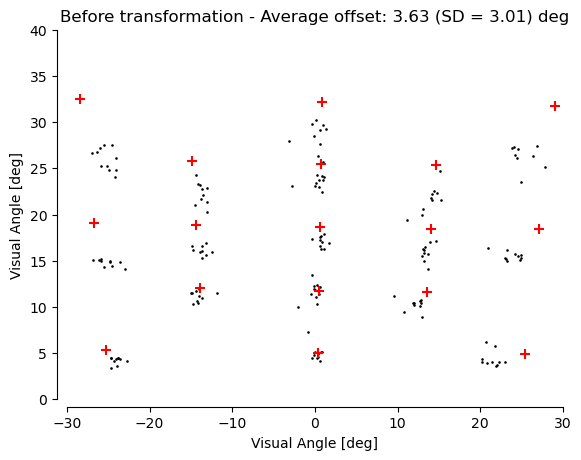

In [57]:
# plot an example 
fig, ax = plt.subplots()
ax.scatter(median_gaze_positions['gaze x [deg]'], median_gaze_positions['gaze y [deg]'], marker='.', c='black', s=3)
ax.scatter(targets['target x [deg]'], targets['target y [deg]'], marker='+', c='red', s=50)
ax.set_xlabel('Visual Angle [deg]')
ax.set_ylabel('Visual Angle [deg]')
ax.set_xlim([-30, 30])
ax.set_ylim([0, 40])
ax.set_title(f"Before transformation - Average offset: {np.round(np.mean(median_gaze_positions['offset']),2)} (SD = {np.round(np.std(median_gaze_positions['offset']),2)}) deg")
cf.xy_axis_format(ax)


In [58]:
# load gaze calibration params
import json 

calibration_param_dir = sub_dir+'/gaze_calibration_params.json'
with open(calibration_param_dir, 'r') as file:
    params = json.load(file)
    
# use affine transfomration to convert gaze points
af = tf.AffineTransform(matrix = np.array(params['tf_matrix_deg']))
gaze_transformed = af(median_gaze_positions[['gaze x [deg]','gaze y [deg]']].values)

# compute the offset 
offset_after = np.linalg.norm(gaze_transformed - median_gaze_positions[['target x [deg]', 'target y [deg]']], axis=1)

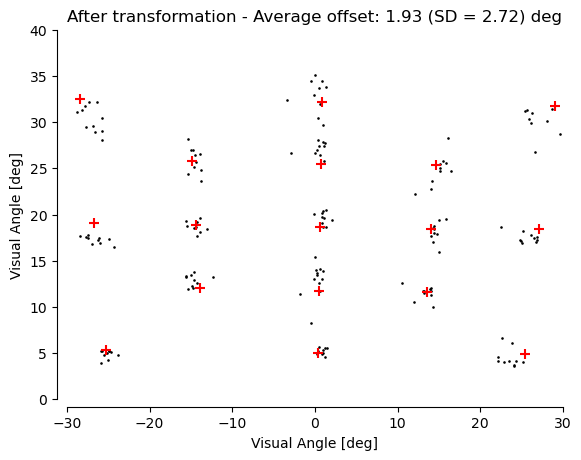

In [59]:
# plot figure after transformation 
fig, ax = plt.subplots()
ax.scatter(gaze_transformed[:,0], gaze_transformed[:,1], marker='.', c='black', s=3)
ax.scatter(targets['target x [deg]'], targets['target y [deg]'], marker='+', c='red', s=50)
ax.set_xlabel('Visual Angle [deg]')
ax.set_ylabel('Visual Angle [deg]')
ax.set_title(f"After transformation - Average offset: {np.round(np.mean(offset_after),2)} (SD = {np.round(np.std(offset_after),2)}) deg")
ax.set_xlim([-30, 30])
ax.set_ylim([0, 40])
cf.xy_axis_format(ax)
